<a href="https://colab.research.google.com/github/CPernet/OpenNeuro_MetaPrivAssessment/blob/main/EEGAlcoholImageryReinforcementLearningTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Link to the repo and import local data and library

In [1]:
# Import Libraries
!git clone https://github.com/CPernet/OpenNeuro_MetaPrivAssessment.git

import sys
sys.path.append("..")
import os
os.chdir('OpenNeuro_MetaPrivAssessment') # Change directory to the cloned repository

Cloning into 'OpenNeuro_MetaPrivAssessment'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 177 (delta 65), reused 97 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (177/177), 3.31 MiB | 7.80 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [2]:
%%bash
set -e
sudo apt-get update -qq
sudo DEBIAN_FRONTEND=noninteractive \
     apt-get install -qq -y --no-install-recommends r-base r-base-dev

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr, kendalltau, linregress
import warnings
warnings.filterwarnings('ignore')
!pip install piflib
import logging
logging.getLogger('rpy2.rinterface_lib.callbacks').setLevel(logging.ERROR)
!pip install -q rpy2
import metaprivBIDS_stat as ST
from metaprivBIDS_stat import plot_calc
from metaprivBIDS_stat import rst_outlier_case2

# Import result files from metaprivBIDS App analysis

AL_IMAGE is the raw dataset EEG: Alcohol imagery reinforcement learning task with participants having light and heavy alcohol consumption


In [4]:
AL_IMAGE = 'https://s3.amazonaws.com/openneuro.org/ds004515/participants.tsv?versionId=OX_rM1XL_frHnMPy12BwJttx3nN3k8kn'
AL_IMAGE = pd.read_csv(AL_IMAGE, sep='\t')
AL_IMAGE.to_csv('EEGAlcoholImageryReinforcementLearningTask/data_ds004515/AL_IMAGE_dataset_ds004515.csv', sep=',', index=False)

In [5]:
AL_IMAGE.head()

,participant_id,Original_ID,sex,age,GROUP,BDI,AUDIT,EDUCATION
0,sub-001,10600,F,43,CTL,14,1,16
1,sub-002,10601,F,50,CTL,2,2,16
2,sub-003,10602,F,22,CTL,2,1,18
3,sub-004,10603,F,18,CTL,0,1,13
4,sub-005,10604,M,31,CTL,1,1,14


The selected quasi identifers are:
- age
- sex
- GROUP
- BDI
- AUDIT
- EDUCATION

The selected sensitive variables are:
- BDI, AUDIT & GROUP


# PIF & SUDA Outliers

In [7]:
suda = pd.read_csv('EEGAlcoholImageryReinforcementLearningTask/data_ds004515/SUDA_ds004515.csv', sep=',')
pif = pd.read_csv('EEGAlcoholImageryReinforcementLearningTask/data_ds004515/PIF_ds004515.csv', sep=',',index_col='Unnamed: 0').sort_index()

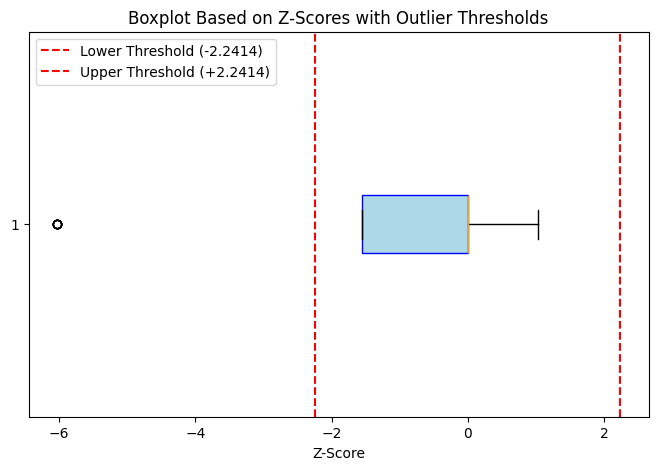

number of outliers found 0


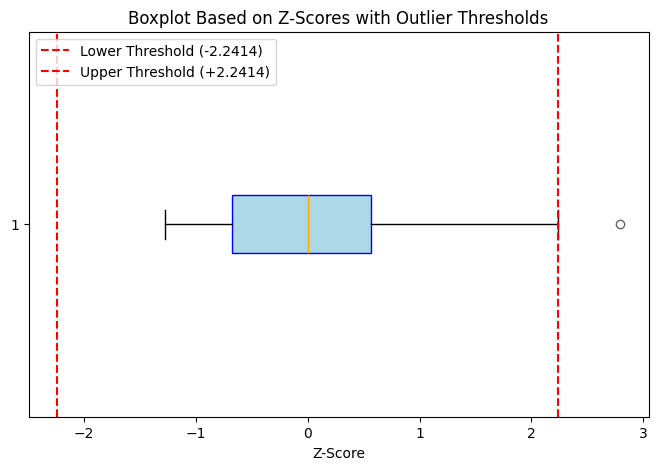

number of outliers found 4
Joint outlier indices: []


In [8]:
# SUDA outliers
results_suda = ST.rst_outlier_case2(suda, 'dis-score')
above_SUDAoutlier_indices = set(results_suda[4]) # Assuming the 4th element (index 3) is the list of outlier indices
print('number of outliers found',len(above_SUDAoutlier_indices))

#PIF outliers
results_pif = ST.rst_outlier_case2(pif, 'RIG')
above_PIFoutlier_indices = set(results_pif[4]) # Assuming the 4th element (index 3) is the list of outlier indices
print('number of outliers found',len(above_PIFoutlier_indices))

# Find the intersection of the two sets
joint_outlier_indices_set = above_SUDAoutlier_indices.intersection(above_PIFoutlier_indices)
joint_outlier_indices = list(joint_outlier_indices_set)
print("Joint outlier indices:", joint_outlier_indices)

## Selected outlier participant

In [11]:
list_above_PIFoutlier_indices

[16, 41, 35, 30]

In [ ]:
AL_IMAGE.loc[30]

participant_id    sub-031
Original_ID         10632
sex                     F
age                    25
GROUP                 ALC
BDI                    14
AUDIT                   5
EDUCATION              15
Name: 30, dtype: object

# Correlation among privacy metrics.

In [12]:
correlation_spearman, p_value = spearmanr(suda['dis-score'], pif['RIG'])
print(f"Spearman Rank Correlation between suda & pif: {correlation_spearman:.3f},p-Value {p_value:.10f}")

Spearman Rank Correlation between suda & pif: 0.679,p-Value 0.0000000163


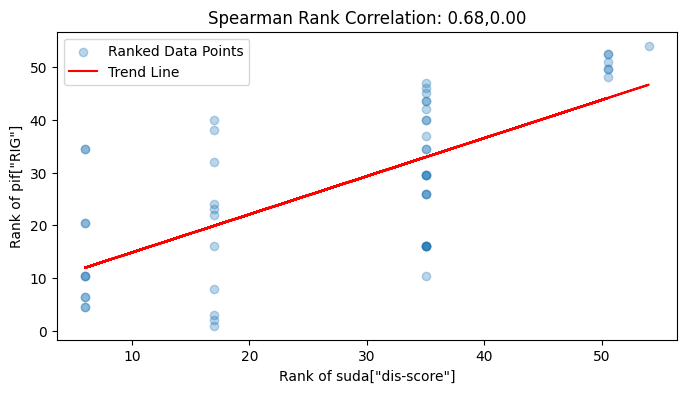

In [14]:
from scipy.stats import rankdata
import matplotlib.pyplot as plt

suda_ranked = rankdata(suda['dis-score'])
pif_ranked = rankdata(pif['RIG'])
fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(suda_ranked, pif_ranked, alpha=0.3, label='Ranked Data Points')
slope, intercept, _, _, _ = linregress(suda_ranked, pif_ranked)
ax.plot(suda_ranked, slope * suda_ranked + intercept, color='red', label='Trend Line')
ax.set_title(f'Spearman Rank Correlation: {correlation_spearman:.2f},{p_value:.2f}')
ax.set_xlabel('Rank of suda["dis-score"]')
ax.set_ylabel('Rank of pif["RIG"]')
ax.grid(False)
ax.legend()
plt.show()

In [15]:
AL_IMAGE['GROUP'].value_counts()

,count
GROUP,
ALC,28
CTL,26
